In [1]:
import sys
sys.path.append('../')

from common_imports import *
from common_functions import *

In [2]:
df = pd.read_csv("lookup.csv")
df, weather_features = preprocess_df(df)
sequence_length = 15

In [3]:
avant_2018 = df[(df['datetime'] < '2018-01-01')]
apres_2018 = df[(df['datetime'] >= '2018-01-01')]
cities = df['name'].unique()

In [4]:
def dynamic_weighted_binary_crossentropy(y_true, y_pred):
    # Ensure y_true is float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Calculate the proportion of positive and negative samples in the batch
    positive_count = tf.reduce_sum(y_true)  # Number of positives
    negative_count = tf.reduce_sum(1.0 - y_true)  # Number of negatives
    
    # Avoid division by zero
    total_count = positive_count + negative_count
    positive_weight = negative_count / total_count  # Weight for positives
    negative_weight = positive_count / total_count  # Weight for negatives
    
    # Assign weights dynamically
    weights = tf.where(y_true == 1, positive_weight, negative_weight)
    
    # Compute binary crossentropy
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply weights and compute the mean
    return tf.reduce_mean(weights * loss)


In [5]:
# Compile the LSTM model
model = LSTM_model(
    sequence_length=sequence_length,
    weather_features=weather_features,
    lstm_units=[64, 128],
    dropout_rates=[0.2, 0.3],
    batch_norm=True,
    reg_l2=0.01
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'fire_output': dynamic_weighted_binary_crossentropy,
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

In [6]:
X_train, y_train_fire, y_train_severity, X_val, y_val_fire, y_val_severity, X_test, y_test_fire, y_test_severity = train_val_test(
    avant_2018, apres_2018, cities, sequence_length, weather_features
)

In [7]:
X_train_array = np.stack(X_train['weather_data'].values)
X_val_array = np.stack(X_val['weather_data'].values)

Epoch 1/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - fire_output_accuracy: 0.9165 - fire_output_f1_score: 34.5473 - fire_output_loss: 0.0777 - loss: 0.4215 - severity_output_loss: 0.3100 - severity_output_mae: 0.6161 - val_fire_output_accuracy: 0.9147 - val_fire_output_f1_score: 55.4523 - val_fire_output_loss: 0.0178 - val_loss: 0.3483 - val_severity_output_loss: 0.3022 - val_severity_output_mae: 0.6998
Epoch 2/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - fire_output_accuracy: 0.9190 - fire_output_f1_score: 34.4672 - fire_output_loss: 0.0746 - loss: 0.4071 - severity_output_loss: 0.3028 - severity_output_mae: 0.6104 - val_fire_output_accuracy: 0.8991 - val_fire_output_f1_score: 54.6819 - val_fire_output_loss: 0.0189 - val_loss: 0.3731 - val_severity_output_loss: 0.3263 - val_severity_output_mae: 0.7311
Epoch 3/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - fire_output_accuracy: 0.9235 - fire_output_f1_score: 34.6148 - fire_output_loss: 0.0695 - loss: 0.3967 - severity_outp

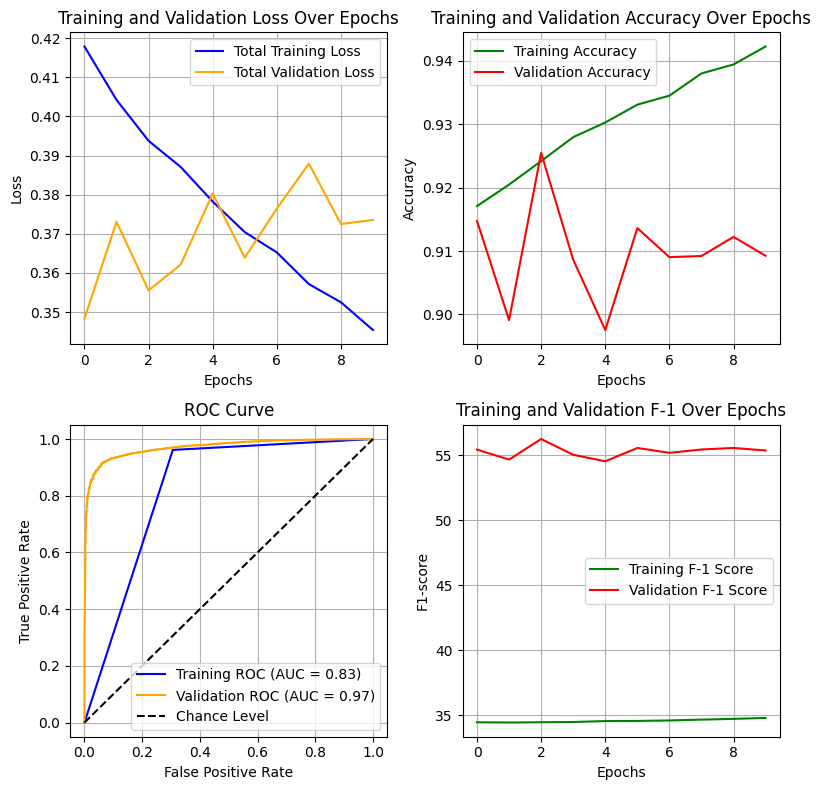

In [9]:
interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, model
)


plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0            0.925176   
1 2019-04-17  Antioch, CA               0         0            0.865664   
2 2019-04-18  Antioch, CA               0         0            0.606997   
3 2019-04-19  Antioch, CA               0         0            0.089642   
4 2019-04-20  Antioch, CA               0         0            0.000000   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
[[5931  375]
 [ 799  166]]


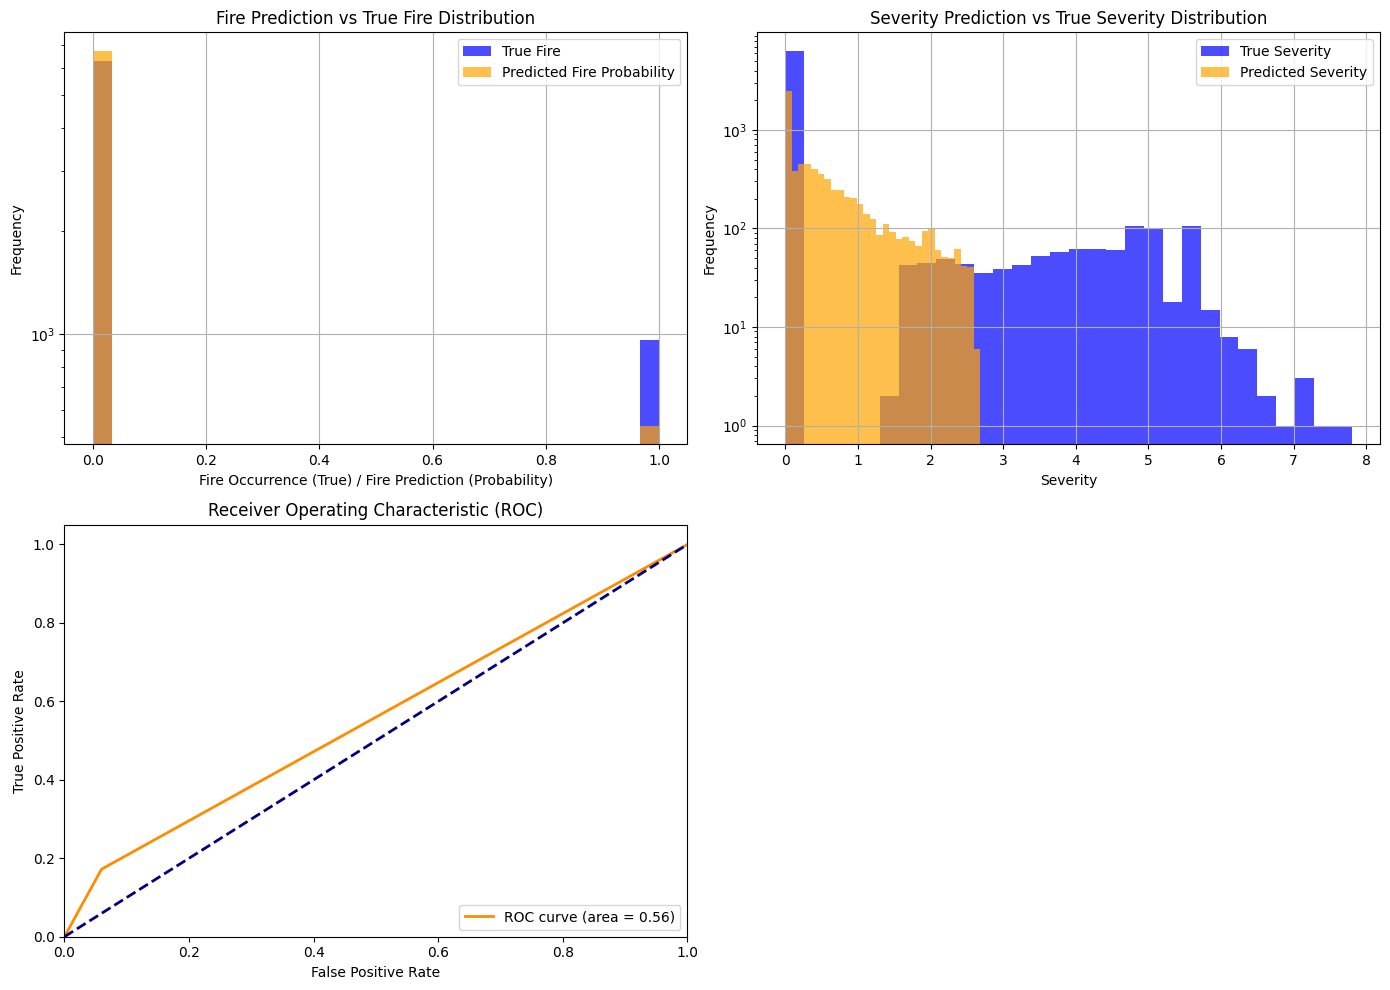

In [10]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, model, threshold=0.8)
plot_result_df(results_df)

In [11]:
model = LSTM_model(
    sequence_length=sequence_length,
    weather_features=weather_features,
    lstm_units=[64, 128],
    dropout_rates=[0.4, 0.4],
    batch_norm=True,
    reg_l2=0.1
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        'fire_output': dynamic_weighted_binary_crossentropy,
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

Epoch 1/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - fire_output_accuracy: 0.8956 - fire_output_f1_score: 34.7487 - fire_output_loss: 0.0922 - loss: 0.4606 - severity_output_loss: 0.3354 - severity_output_mae: 0.6716 - val_fire_output_accuracy: 0.8790 - val_fire_output_f1_score: 53.4298 - val_fire_output_loss: 0.0217 - val_loss: 0.4020 - val_severity_output_loss: 0.3507 - val_severity_output_mae: 0.7255
Epoch 2/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - fire_output_accuracy: 0.9028 - fire_output_f1_score: 34.5819 - fire_output_loss: 0.0869 - loss: 0.4371 - severity_output_loss: 0.3194 - severity_output_mae: 0.6493 - val_fire_output_accuracy: 0.8787 - val_fire_output_f1_score: 53.4498 - val_fire_output_loss: 0.0214 - val_loss: 0.3993 - val_severity_output_loss: 0.3489 - val_severity_output_mae: 0.7178
Epoch 3/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - fire_output_accuracy: 0.9019 - fire_output_f1_score: 34.2660 - fire_output_loss: 0.0882 - loss: 0.4484 - severity_outp

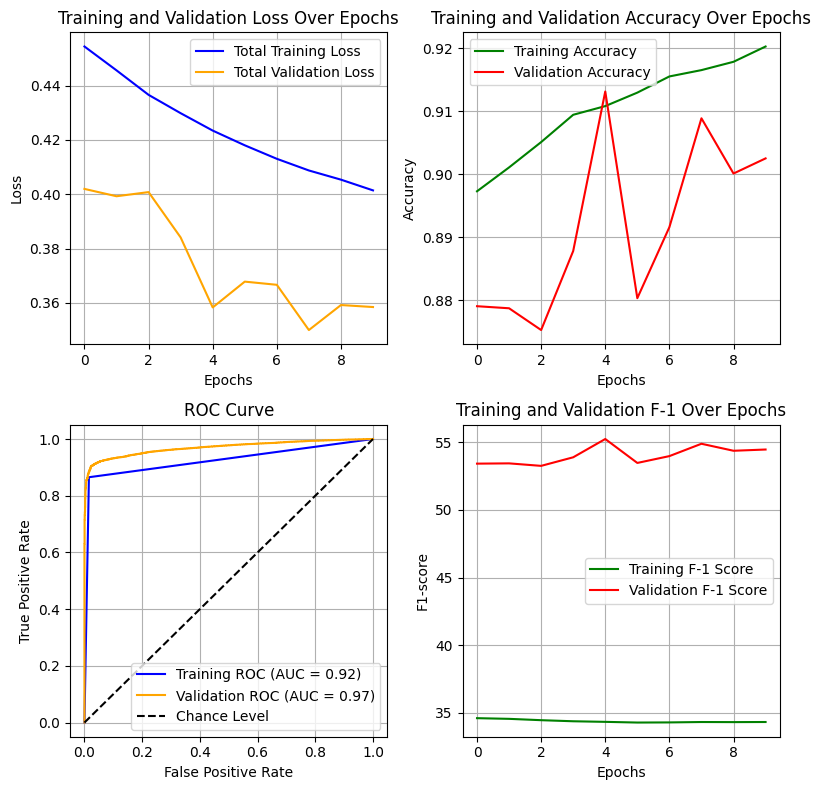

In [14]:
interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, model
)


plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0            0.384048   
1 2019-04-17  Antioch, CA               0         0            0.518031   
2 2019-04-18  Antioch, CA               0         0            0.467226   
3 2019-04-19  Antioch, CA               0         0            0.405455   
4 2019-04-20  Antioch, CA               0         0            0.211435   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
[[5980  326]
 [ 818  147]]


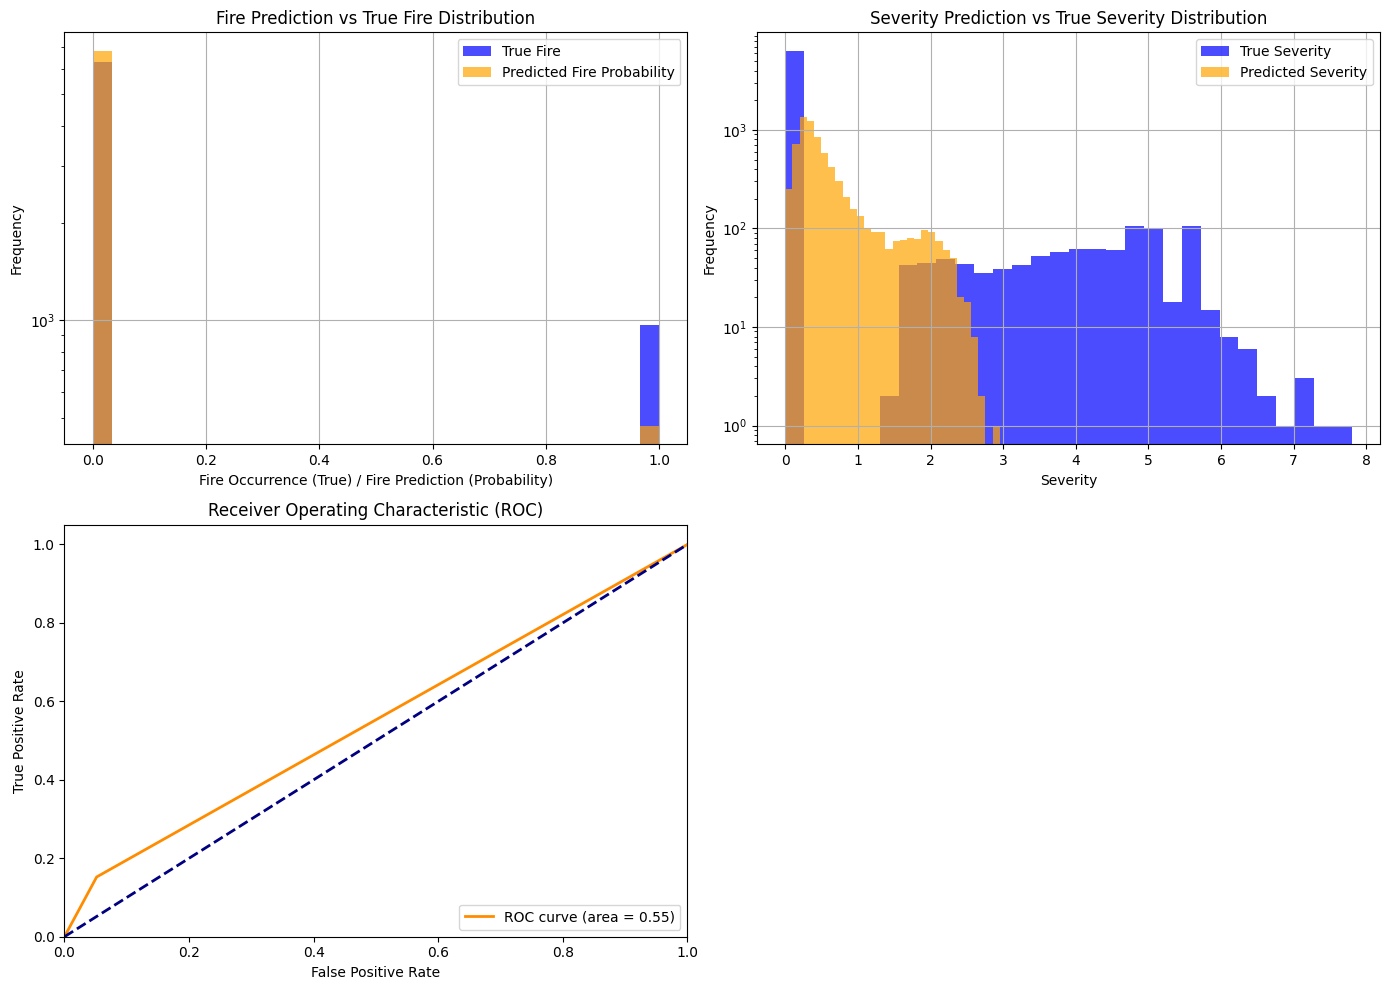

In [18]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, model, threshold=0.8)
plot_result_df(results_df)

Epoch 1/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - fire_output_accuracy: 0.7253 - fire_output_f1_score: 35.4376 - fire_output_loss: 0.1948 - loss: 1.1741 - severity_output_loss: 0.6561 - severity_output_mae: 0.9826 - val_fire_output_accuracy: 0.8631 - val_fire_output_f1_score: 54.1827 - val_fire_output_loss: 0.0187 - val_loss: 0.5961 - val_severity_output_loss: 0.3577 - val_severity_output_mae: 0.7308
Epoch 2/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - fire_output_accuracy: 0.8561 - fire_output_f1_score: 35.2979 - fire_output_loss: 0.1176 - loss: 0.6850 - severity_output_loss: 0.3741 - severity_output_mae: 0.6738 - val_fire_output_accuracy: 0.8889 - val_fire_output_f1_score: 54.7045 - val_fire_output_loss: 0.0200 - val_loss: 0.4892 - val_severity_output_loss: 0.3452 - val_severity_output_mae: 0.7242
Epoch 3/10
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - fire_output_accuracy: 0.8867 - fire_output_f1_score: 35.1219 - fire_output_loss: 0.0956 - loss: 0.5438 - severity_outp

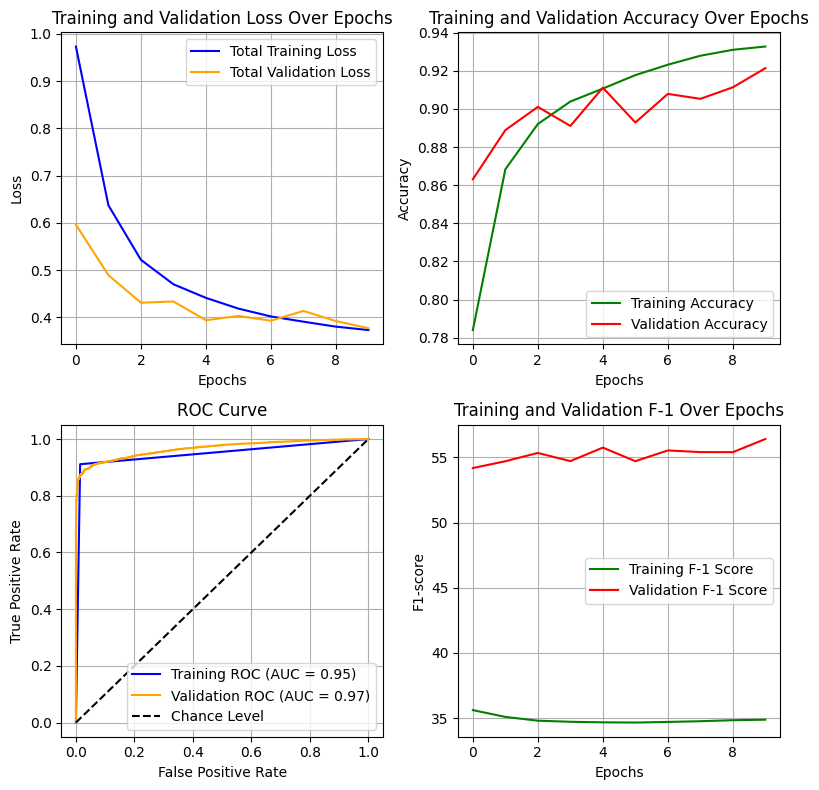

In [19]:
model = LSTM_model(
    sequence_length=sequence_length,
    weather_features=weather_features,
    lstm_units=[64, 128, 256],
    dropout_rates=[0.3, 0.4, 0.4],
    batch_norm=True,
    reg_l2=0.001
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        'fire_output': dynamic_weighted_binary_crossentropy,
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, model
)


plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0            1.029486   
1 2019-04-17  Antioch, CA               0         0            1.277303   
2 2019-04-18  Antioch, CA               0         0            0.625595   
3 2019-04-19  Antioch, CA               0         0            0.161612   
4 2019-04-20  Antioch, CA               0         0            0.000000   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
[[5703  603]
 [ 813  152]]


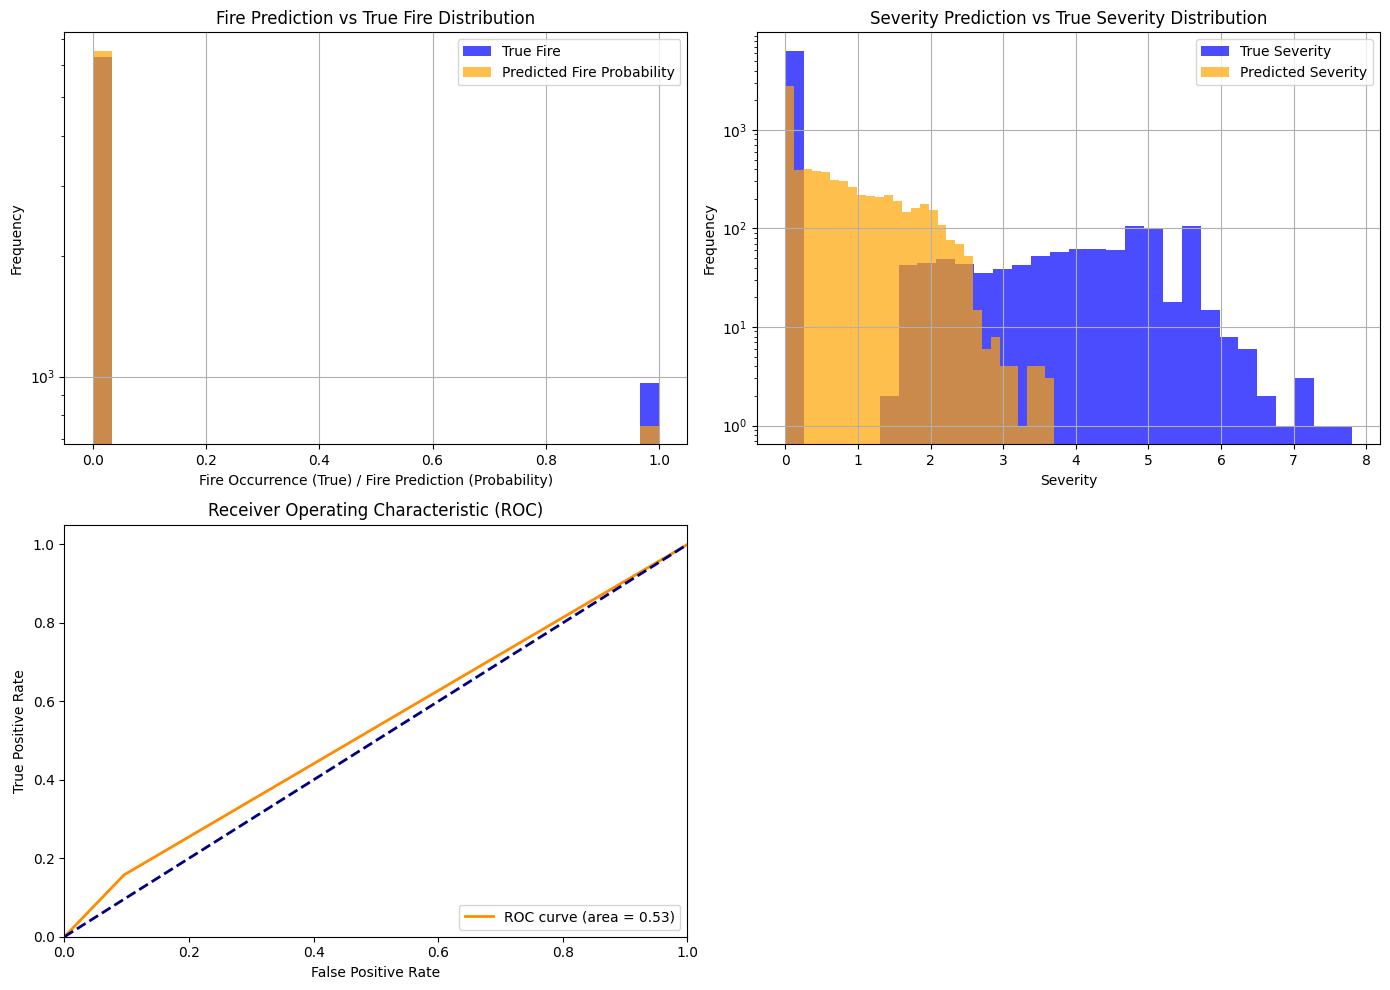

In [22]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, model, threshold=0.8)
plot_result_df(results_df)